In [1]:
!pip install scikit-fuzzy

   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/920.8 kB ? eta -:--:--
   ---------------------- ----------------- 524.3/920.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------- ----- 786.4/920.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 920.8/920.8 kB 870.1 kB/s  0:00:00


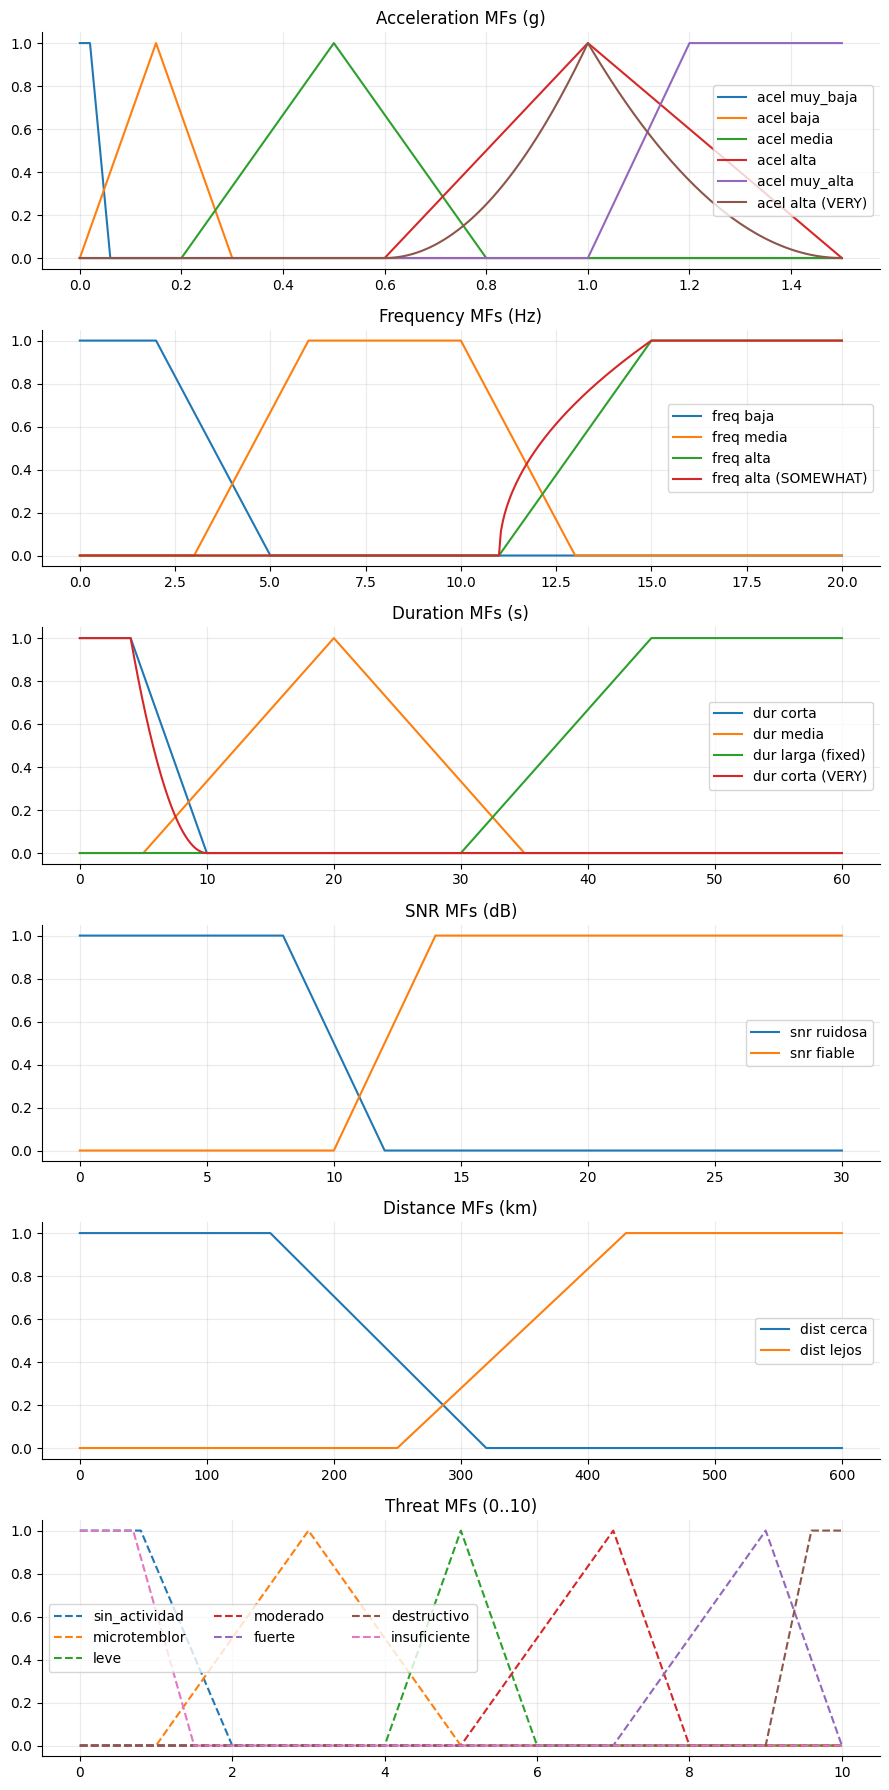

### Fuzzy Rules

HTML(value="<pre style='white-space:pre-wrap'>R0a IF snr is ruidosa AND acel is muy_baja AND dist is lejos    …

Button(button_style='primary', description='Compute', style=ButtonStyle())

Output()

Output()

In [5]:
# ===========================================
# FUZZY EXPERT SYSTEM — EARTHQUAKE THREAT (Mamdani/Larsen)
# This revision applies ONLY the requested items:
# A) Expose configurable t-norm / s-norm / aggregator in UI + CLI
# B) Fix: no silent fallback on invalid operator names (fail fast)
# (Everything else remains unchanged.)
# ===========================================

from typing import Dict, List, Tuple, Optional
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# ----------------------------
# 0) PARAMETERS (easy to tweak)
# ----------------------------
# Universes
X_ACEL_MAX = 1.5
X_FREQ_MAX = 20.0
X_DUR_MAX  = 60.0
X_SNR_MAX  = 30.0
X_DIST_MAX = 600.0
X_THREAT_MAX = 10.0

# Grids
x_acel   = np.linspace(0.0, X_ACEL_MAX, 301)       # ground acceleration (g)
x_freq   = np.linspace(0.0, X_FREQ_MAX, 401)       # dominant frequency (Hz)
x_dur    = np.linspace(0.0, X_DUR_MAX, 601)        # event duration (s)
x_snr    = np.linspace(0.0, X_SNR_MAX, 301)        # SNR (dB)
x_dist   = np.linspace(0.0, X_DIST_MAX, 601)       # epicentral distance (km)
x_threat = np.linspace(0.0, X_THREAT_MAX, 1001)    # threat (0..10)

# Label tie-break policy when μs are ~tied at the crisp point.
# "lower"  → prefer lower-severity label on near-ties (conservative)
# "higher" → prefer higher-severity label on near-ties (alarmist)
TIE_BREAK_POLICY = "lower"
TIE_EPS = 1e-2  # relaxed per request

# Severity ordering from low → high (used for deterministic tie-break)
SEVERITY_ORDER = [
    "insuficiente",  # added explicitly per request
    "sin_actividad", "microtemblor", "leve",
    "moderado", "fuerte", "destructivo"
]

# Health-check thresholds (named constants, clearer messages)
PEAK_THR_BASE = 0.999   # base sets should peak ~1
PEAK_THR_MODS = 0.90    # modifier-derived sets (hedges) may peak < 1

# ----------------------------
# 0.1) FUZZY CONFIG (requested)
# ----------------------------
# Supported modes:
#   tnorm: 'min' | 'prod'
#   snorm: 'max' | 'bsum' (bounded sum) | 'asum' (algebraic sum)
#   aggregator: same set as snorm, applied element-wise to consequent sets
FUZZY_CFG = {
    "tnorm": "min",
    "snorm": "max",
    "aggregator": "max",
}

VALID_TNORMS = {"min", "prod"}
VALID_SNORMS = {"max", "bsum", "asum"}
VALID_AGGS   = {"max", "bsum", "asum"}

def _validate_ops(tnorm: str, snorm: str, aggregator: Optional[str] = None) -> None:
    if tnorm not in VALID_TNORMS:
        raise ValueError(f"Unsupported t-norm '{tnorm}'. Supported: {sorted(VALID_TNORMS)}")
    if snorm not in VALID_SNORMS:
        raise ValueError(f"Unsupported s-norm '{snorm}'. Supported: {sorted(VALID_SNORMS)}")
    if aggregator is not None and aggregator not in VALID_AGGS:
        raise ValueError(f"Unsupported aggregator '{aggregator}'. Supported: {sorted(VALID_AGGS)}")

# Optional per-rule weights (scalar in [0,1]); default 1.0 for all rules.
# You can override any of these externally before calling mamdani_infer(..., rule_weights=...)
RULE_TAGS = ["R0a","R0b","R1","R2","R3","R4","R5","R6","R7","R8","R9",
             "R10","R11","R12","R13","R14","R15","R16","R17","R18"]
RULE_WEIGHTS_DEFAULT: Dict[str, float] = {t: 1.0 for t in RULE_TAGS}

# -----------------------------
# Helper ops for fuzzy calculus
# -----------------------------
def _tnorm2(a: float, b: float, mode: str) -> float:
    if mode == "prod":
        return float(a * b)
    if mode == "min":
        return float(min(a, b))
    # no silent fallback:
    raise ValueError(f"Unsupported t-norm '{mode}'")

def _snorm2(a: float, b: float, mode: str) -> float:
    if mode == "bsum":   # bounded sum
        return float(min(1.0, a + b))
    if mode == "asum":   # algebraic sum
        return float(a + b - a * b)
    if mode == "max":
        return float(max(a, b))
    # no silent fallback:
    raise ValueError(f"Unsupported s-norm '{mode}'")

def _tnorm_n(vals: List[float], mode: str) -> float:
    if not vals:
        return 0.0
    acc = float(vals[0])
    for v in vals[1:]:
        acc = _tnorm2(acc, float(v), mode)
    return float(acc)

def _snorm_n(vals: List[float], mode: str) -> float:
    if not vals:
        return 0.0
    acc = float(vals[0])
    for v in vals[1:]:
        acc = _snorm2(acc, float(v), mode)
    return float(acc)

def _agg_arrays(a: np.ndarray, b: np.ndarray, mode: str) -> np.ndarray:
    if mode == "bsum":
        return np.clip(a + b, 0.0, 1.0)
    if mode == "asum":
        return np.clip(a + b - a * b, 0.0, 1.0)
    if mode == "max":
        return np.fmax(a, b)
    # no silent fallback:
    raise ValueError(f"Unsupported aggregator '{mode}'")

# ----------------------------------
# 1) MEMBERSHIP FUNCTIONS (MFs)
#    (use shoulder trapezoids to avoid degenerate triangles)
# ----------------------------------
# 1.1 Acceleration
acel_muy_baja = fuzz.trapmf(x_acel, [0.00, 0.00, 0.02, 0.06])
acel_baja     = fuzz.trimf (x_acel, [0.00, 0.15, 0.30])
acel_media    = fuzz.trimf (x_acel, [0.20, 0.50, 0.80])
acel_alta     = fuzz.trimf (x_acel, [0.60, 1.00, 1.50])
acel_muy_alta = fuzz.trapmf(x_acel, [1.00, 1.20, 1.50, 1.50])

# Modifiers (hedges)
acel_alta_very = np.power(acel_alta, 2.0)     # VERY(high)

# 1.2 Frequency
freq_baja      = fuzz.trapmf(x_freq, [0.0, 0.0, 2.0, 5.0])
freq_media     = fuzz.trapmf(x_freq, [3.0, 6.0,10.0,13.0])
freq_alta      = fuzz.trapmf(x_freq, [11.0,15.0,20.0,20.0])
freq_alta_some = np.sqrt(freq_alta)           # SOMEWHAT(high)

# 1.3 Duration (fix: non-degenerate right shoulder)
dur_corta      = fuzz.trapmf(x_dur, [0.0, 0.0, 4.0, 10.0])
dur_media      = fuzz.trimf (x_dur, [5.0, 20.0, 35.0])
dur_larga      = fuzz.trapmf(x_dur, [30.0, 45.0, 60.0, 60.0])
dur_corta_very = np.power(dur_corta, 2.0)     # VERY(short)

# 1.4 SNR
snr_ruidosa = fuzz.trapmf(x_snr, [0.0, 0.0, 8.0, 12.0])      # noisy if low SNR
snr_fiable  = fuzz.trapmf(x_snr, [10.0,14.0,30.0,30.0])      # reliable if high SNR

# 1.5 Distance
dist_cerca = fuzz.trapmf(x_dist, [0.0, 0.0,150.0,320.0])
dist_lejos = fuzz.trapmf(x_dist, [250.0,430.0,600.0,600.0])

# 1.6 Output: THREAT (safer shoulders on extremes)
th_sin    = fuzz.trapmf(x_threat, [0.0, 0.0, 0.8, 2.0])      # sin_actividad
th_micro  = fuzz.trimf (x_threat, [1.0, 3.0, 5.0])           # microtemblor
th_leve   = fuzz.trimf (x_threat, [4.0, 5.0, 6.0])           # leve
th_moder  = fuzz.trimf (x_threat, [5.0, 7.0, 8.0])           # moderado
th_fuerte = fuzz.trimf (x_threat, [7.0, 9.0,10.0])           # fuerte
th_destr  = fuzz.trapmf(x_threat, [9.0, 9.6,10.0,10.0])      # destructivo
th_insuf  = fuzz.trapmf(x_threat, [0.0, 0.0, 0.7, 1.5])      # insuficiente

# Helper: consequents dictionary
THSETS = {
    "sin_actividad": th_sin,
    "microtemblor":  th_micro,
    "leve":          th_leve,
    "moderado":      th_moder,
    "fuerte":        th_fuerte,
    "destructivo":   th_destr,
    "insuficiente":  th_insuf,
}

# Label mapping (ES → EN)
LABEL_MAP_EN = {
    "sin_actividad": "No seismic activity",
    "microtemblor":  "Microtremor",
    "leve":          "Mild earthquake",
    "moderado":      "Moderate earthquake",
    "fuerte":        "Strong earthquake",
    "destructivo":   "Destructive earthquake",
    "insuficiente":  "Insufficient evidence",
}

# ---------------------------
# 2) FUZZIFICATION HELPERS
# ---------------------------
def μ_acel(a: float) -> Dict[str, float]:
    return {
        "muy_baja":  float(fuzz.interp_membership(x_acel, acel_muy_baja, a)),
        "baja":      float(fuzz.interp_membership(x_acel, acel_baja,     a)),
        "media":     float(fuzz.interp_membership(x_acel, acel_media,    a)),
        "alta":      float(fuzz.interp_membership(x_acel, acel_alta,     a)),
        "muy_alta":  float(fuzz.interp_membership(x_acel, acel_muy_alta, a)),
        "alta_very": float(fuzz.interp_membership(x_acel, acel_alta_very, a)),
    }

def μ_freq(f: float) -> Dict[str, float]:
    return {
        "baja":       float(fuzz.interp_membership(x_freq, freq_baja,      f)),
        "media":      float(fuzz.interp_membership(x_freq, freq_media,     f)),
        "alta":       float(fuzz.interp_membership(x_freq, freq_alta,      f)),
        "alta_some":  float(fuzz.interp_membership(x_freq, freq_alta_some, f)),
    }

def μ_dur(d: float) -> Dict[str, float]:
    return {
        "corta":       float(fuzz.interp_membership(x_dur, dur_corta,      d)),
        "media":       float(fuzz.interp_membership(x_dur, dur_media,      d)),
        "larga":       float(fuzz.interp_membership(x_dur, dur_larga,      d)),
        "corta_very":  float(fuzz.interp_membership(x_dur, dur_corta_very, d)),
    }

def μ_snr(s: float) -> Dict[str, float]:
    return {
        "ruidosa": float(fuzz.interp_membership(x_snr, snr_ruidosa, s)),
        "fiable":  float(fuzz.interp_membership(x_snr, snr_fiable,  s)),
    }

def μ_dist(x: float) -> Dict[str, float]:
    return {
        "cerca": float(fuzz.interp_membership(x_dist, dist_cerca, x)),
        "lejos": float(fuzz.interp_membership(x_dist, dist_lejos, x)),
    }

# ---------------------------------------------
# 3) RULES (R0..R18) — centralized computation
#    AND/OR use configurable t-norm / s-norm (requested).
#    Per-rule weights applied before implication (requested).
# ---------------------------------------------
RULES_DOC = r"""
R0a IF snr is ruidosa AND acel is muy_baja AND dist is lejos               THEN amenaza is insuficiente
R0b IF snr is ruidosa AND dur  is corta    AND dist is lejos               THEN amenaza is insuficiente

R1  IF acel is alta AND dur is corta AND dist is cerca AND snr is fiable   THEN amenaza is fuerte
R2  IF acel is alta AND dur is larga AND dist is cerca AND snr is fiable   THEN amenaza is destructivo
R3  IF acel is alta AND freq is alta AND dist is cerca AND snr is fiable   THEN amenaza is fuerte
R4  IF acel is alta AND dist is lejos AND snr is fiable                    THEN amenaza is moderado
R5  IF acel is media AND freq is alta AND dist is cerca AND snr is fiable  THEN amenaza is leve
R6  IF acel is media AND dur  is media AND dist is cerca AND snr is fiable THEN amenaza is moderado
R7  IF acel is media AND dur  is larga AND dist is cerca AND snr is fiable THEN amenaza is moderado
R8  IF acel is baja  AND freq is alta AND dur is corta AND snr is fiable   THEN amenaza is sin_actividad
R9  IF acel is baja  AND dur  is corta AND dist is lejos AND snr is fiable THEN amenaza is sin_actividad
R10 IF acel is baja  AND dur  is larga AND dist is cerca AND snr is fiable THEN amenaza is microtemblor
R11 IF freq is baja AND dur  is larga AND dist is cerca AND snr is fiable  THEN amenaza is fuerte

-- noisy evidence (snr ruidosa) → conservative mapping (never above 'moderado') --
R12 IF snr is ruidosa AND acel is alta  AND dist is cerca                   THEN amenaza is moderado
R13 IF snr is ruidosa AND acel is media AND dist is cerca                   THEN amenaza is leve
R14 IF snr is ruidosa AND acel is baja                                      THEN amenaza is microtemblor
R15 IF snr is ruidosa AND dist is lejos                                     THEN amenaza is sin_actividad

-- general distance/effect trade-offs --
R16 IF dist is cerca AND (acel is media OR freq is alta) AND snr is fiable  THEN amenaza is moderado
R17 IF dist is lejos AND acel is baja AND dur is media AND snr is fiable    THEN amenaza is microtemblor

-- high-intensity corner (using modifiers per theory) --
R18 IF acel is alta_very AND freq is alta_some AND dur is larga AND dist is cerca
    AND snr is fiable                                                       THEN amenaza is destructivo
""".strip()

def compute_rule_strengths(
    μA: Dict[str, float], μF: Dict[str, float], μD: Dict[str, float],
    μS: Dict[str, float], μX: Dict[str, float],
    *, tnorm: str = None, snorm: str = None, rule_weights: Optional[Dict[str, float]] = None
) -> List[Tuple[float, str, str]]:
    """
    Compute antecedent strengths for all rules using configurable t-norm (AND) and s-norm (OR).
    Applies per-rule weight w[tag] in [0,1] BEFORE implication, i.e., strength := w[tag] * strength.
    Returns list of (strength, consequent_name_es, rule_tag).
    """
    tnorm = (tnorm or FUZZY_CFG["tnorm"]).lower()
    snorm = (snorm or FUZZY_CFG["snorm"]).lower()
    _validate_ops(tnorm, snorm)  # fail fast on invalid names
    w = (rule_weights or RULE_WEIGHTS_DEFAULT)

    out: List[Tuple[float, str, str]] = []

    # R0a / R0b
    r = _tnorm_n([μS["ruidosa"], μA["muy_baja"], μX["lejos"]], tnorm); out.append((w["R0a"] * float(r), "insuficiente", "R0a"))
    r = _tnorm_n([μS["ruidosa"], μD["corta"],     μX["lejos"]], tnorm); out.append((w["R0b"] * float(r), "insuficiente", "R0b"))

    # R1..R11
    r = _tnorm_n([μA["alta"],  μD["corta"], μX["cerca"], μS["fiable"]], tnorm); out.append((w["R1"]  * float(r), "fuerte",        "R1"))
    r = _tnorm_n([μA["alta"],  μD["larga"], μX["cerca"], μS["fiable"]], tnorm); out.append((w["R2"]  * float(r), "destructivo",   "R2"))
    r = _tnorm_n([μA["alta"],  μF["alta"],  μX["cerca"], μS["fiable"]], tnorm); out.append((w["R3"]  * float(r), "fuerte",        "R3"))
    r = _tnorm_n([μA["alta"],  μX["lejos"], μS["fiable"]],               tnorm); out.append((w["R4"]  * float(r), "moderado",      "R4"))
    r = _tnorm_n([μA["media"], μF["alta"],  μX["cerca"], μS["fiable"]],  tnorm); out.append((w["R5"]  * float(r), "leve",          "R5"))
    r = _tnorm_n([μA["media"], μD["media"], μX["cerca"], μS["fiable"]],  tnorm); out.append((w["R6"]  * float(r), "moderado",      "R6"))
    r = _tnorm_n([μA["media"], μD["larga"], μX["cerca"], μS["fiable"]],  tnorm); out.append((w["R7"]  * float(r), "moderado",      "R7"))
    r = _tnorm_n([μA["baja"],  μF["alta"],  μD["corta"], μS["fiable"]],  tnorm); out.append((w["R8"]  * float(r), "sin_actividad", "R8"))
    r = _tnorm_n([μA["baja"],  μD["corta"], μX["lejos"], μS["fiable"]],  tnorm); out.append((w["R9"]  * float(r), "sin_actividad", "R9"))
    r = _tnorm_n([μA["baja"],  μD["larga"], μX["cerca"], μS["fiable"]],  tnorm); out.append((w["R10"] * float(r), "microtemblor",  "R10"))
    r = _tnorm_n([μF["baja"],  μD["larga"], μX["cerca"], μS["fiable"]],  tnorm); out.append((w["R11"] * float(r), "fuerte",        "R11"))

    # R12..R15 (noisy)
    r = _tnorm_n([μS["ruidosa"], μA["alta"],  μX["cerca"]], tnorm); out.append((w["R12"] * float(r), "moderado",      "R12"))
    r = _tnorm_n([μS["ruidosa"], μA["media"], μX["cerca"]], tnorm); out.append((w["R13"] * float(r), "leve",          "R13"))
    r = _tnorm_n([μS["ruidosa"], μA["baja"]],               tnorm); out.append((w["R14"] * float(r), "microtemblor",  "R14"))
    r = _tnorm_n([μS["ruidosa"], μX["lejos"]],              tnorm); out.append((w["R15"] * float(r), "sin_actividad", "R15"))

    # R16 trade-off (explicit OR via chosen s-norm)
    or_term = _snorm2(μA["media"], μF["alta"], snorm)
    r = _tnorm_n([μX["cerca"], or_term, μS["fiable"]], tnorm)
    out.append((w["R16"] * float(r), "moderado", "R16"))

    # R17
    r = _tnorm_n([μX["lejos"], μA["baja"], μD["media"], μS["fiable"]], tnorm)
    out.append((w["R17"] * float(r), "microtemblor", "R17"))

    # R18 high-intensity corner (modifiers)
    r = _tnorm_n([μA["alta_very"], μF["alta_some"], μD["larga"], μX["cerca"], μS["fiable"]], tnorm)
    out.append((w["R18"] * float(r), "destructivo", "R18"))

    return out

# ---------------------------------------------
# 4) Inference
#    returns crisp, label_en, aggregation[, fired_log, top_labels, empty_agg]
#    fired_log entries carry (μ, cons_es, cons_en, rule_tag)
# ---------------------------------------------
def _severity_index(name: str) -> int:
    try:
        return SEVERITY_ORDER.index(name)
    except ValueError:
        return -1

def _label_from_active(
    crisp: float,
    parts_named: List[Tuple[str, np.ndarray]],
    *, tie_policy: str = TIE_BREAK_POLICY, eps: float = TIE_EPS
) -> Tuple[str, List[Tuple[str, float]]]:
    """
    Choose label only among active consequents that contributed.
    Returns (best_label_en, top_labels_with_membership_at_crisp_in_EN)
    """
    if not parts_named:
        # No rule fired → treat as insufficient evidence
        return LABEL_MAP_EN["insuficiente"], []

    scored: List[Tuple[str, float]] = []
    for name, clipped in parts_named:
        mu = float(fuzz.interp_membership(x_threat, clipped, crisp))
        scored.append((name, mu))

    # Sort ONLY by μ desc (no hidden severity bias)
    scored.sort(key=lambda t: t[1], reverse=True)

    # Handle near-ties explicitly using the policy and severity ordering
    top = scored[0]
    rivals = [t for t in scored if abs(t[1] - top[1]) <= eps]
    if len(rivals) > 1:
        if tie_policy == "higher":
            chosen = max(rivals, key=lambda t: _severity_index(t[0]))
        else:
            chosen = min(rivals, key=lambda t: _severity_index(t[0]))
    else:
        chosen = top

    best_label = LABEL_MAP_EN.get(chosen[0], chosen[0])
    # Convert names → English for the top list too
    top_labels = [(LABEL_MAP_EN.get(n, n), mu) for (n, mu) in scored[:3]]
    return best_label, top_labels

def mamdani_infer(
    acel: float, freq: float, dur: float, snr: float, dist_km: float,
    *,
    implication: str = "mamdani",
    defuzz_method: str = "centroid",
    return_rule_firings: bool = False,
    clip_to_domain: bool = True,
    # requested config hooks:
    tnorm: Optional[str] = None,
    snorm: Optional[str] = None,
    aggregator: Optional[str] = None,
    rule_weights: Optional[Dict[str, float]] = None
):
    """
    Evaluate rules and aggregate consequents.

    Parameters
    ----------
    implication : {'mamdani','larsen'}
        'mamdani' uses clipping (min(strength, consequent)).
        'larsen'  uses product scaling (strength * consequent).
    defuzz_method : {'centroid','bisector','mom','som','lom'}
        Defuzzification method for crisp output.
    return_rule_firings : bool
        If True, also returns the fired-rule trace, top labels, and empty_agg flag.
    clip_to_domain : bool
        Clamp inputs into their universes to avoid artificial 'no rule fired'.
    tnorm : {'min','prod'} or None
        AND operator for antecedents. Defaults to FUZZY_CFG['tnorm'] if None.
    snorm : {'max','bsum','asum'} or None
        OR operator for antecedents. Defaults to FUZZY_CFG['snorm'] if None.
    aggregator : {'max','bsum','asum'} or None
        Element-wise aggregator for consequent fuzzy sets. Defaults to FUZZY_CFG['aggregator'] if None.
    rule_weights : dict[str,float] or None
        Optional per-rule weights in [0,1]; applied BEFORE implication.

    Returns
    -------
    If return_rule_firings is False:
        (crisp: float, label_en: str, aggregation: np.ndarray)

    If return_rule_firings is True:
        (crisp: float, label_en: str, aggregation: np.ndarray,
         fired_log: List[Tuple[float, str, str, str]],
         top_labels: List[Tuple[str, float]],
         empty_agg: bool)
    """
    # Input domain clipping
    if clip_to_domain:
        acel = float(np.clip(acel, 0.0, X_ACEL_MAX))
        freq = float(np.clip(freq, 0.0, X_FREQ_MAX))
        dur  = float(np.clip(dur,  0.0, X_DUR_MAX))
        snr  = float(np.clip(snr,  0.0, X_SNR_MAX))
        dist_km = float(np.clip(dist_km, 0.0, X_DIST_MAX))

    # Resolve chosen ops
    tnorm = (tnorm or FUZZY_CFG["tnorm"]).lower()
    snorm = (snorm or FUZZY_CFG["snorm"]).lower()
    aggregator = (aggregator or FUZZY_CFG["aggregator"]).lower()
    _validate_ops(tnorm, snorm, aggregator)  # fail fast

    μA = μ_acel(acel)
    μF = μ_freq(freq)
    μD = μ_dur(dur)
    μS = μ_snr(snr)
    μX = μ_dist(dist_km)

    fired_rules = compute_rule_strengths(μA, μF, μD, μS, μX,
                                         tnorm=tnorm, snorm=snorm, rule_weights=rule_weights)

    parts: List[np.ndarray] = []
    parts_named: List[Tuple[str, np.ndarray]] = []
    fired_log: List[Tuple[float, str, str, str]] = []  # (μ, cons_es, cons_en, rule_tag)

    def add_rule(strength: float, consequent_name_es: str, tag: str):
        if strength <= 0.0:
            return
        cons = THSETS[consequent_name_es]
        if implication == "mamdani":
            clipped = np.fmin(strength, cons)
        elif implication == "larsen":
            clipped = strength * cons
        else:
            raise ValueError("implication must be 'mamdani' or 'larsen'")
        parts.append(clipped)
        parts_named.append((consequent_name_es, clipped))
        fired_log.append((float(strength), consequent_name_es,
                          LABEL_MAP_EN.get(consequent_name_es, consequent_name_es), tag))

    for strength, cons_name, tag in fired_rules:
        add_rule(strength, cons_name, tag)

    # Aggregation (configurable element-wise s-norm)
    if parts:
        aggregation = parts[0].copy()
        for p in parts[1:]:
            aggregation = _agg_arrays(aggregation, p, aggregator)
        empty_agg = False
    else:
        aggregation = np.zeros_like(x_threat)
        empty_agg = True

    # Defuzzification
    try:
        crisp = float(fuzz.defuzz(x_threat, aggregation, defuzz_method))
    except Exception:
        # Degenerate case: all zeros → keep crisp at 0.0 but mark empty
        crisp = 0.0
        empty_agg = True

    # Label selection with deterministic tie-break
    label_en, top_labels = _label_from_active(crisp, parts_named)

    if return_rule_firings:
        fired_log.sort(key=lambda t: t[0], reverse=True)
        return crisp, label_en, aggregation, fired_log, top_labels, empty_agg
    return crisp, label_en, aggregation

# ----------------------------------------------------
# 5) VISUALIZATION
# ----------------------------------------------------
def plot_memberships():
    fig, axs = plt.subplots(6, 1, figsize=(9, 18))

    axs[0].plot(x_acel, acel_muy_baja, label='acel muy_baja')
    axs[0].plot(x_acel, acel_baja,     label='acel baja')
    axs[0].plot(x_acel, acel_media,    label='acel media')
    axs[0].plot(x_acel, acel_alta,     label='acel alta')
    axs[0].plot(x_acel, acel_muy_alta, label='acel muy_alta')
    axs[0].plot(x_acel, acel_alta_very,label='acel alta (VERY)')
    axs[0].set_title('Acceleration MFs (g)'); axs[0].legend(); axs[0].grid(alpha=0.25)

    axs[1].plot(x_freq, freq_baja,      label='freq baja')
    axs[1].plot(x_freq, freq_media,     label='freq media')
    axs[1].plot(x_freq, freq_alta,      label='freq alta')
    axs[1].plot(x_freq, freq_alta_some, label='freq alta (SOMEWHAT)')
    axs[1].set_title('Frequency MFs (Hz)'); axs[1].legend(); axs[1].grid(alpha=0.25)

    axs[2].plot(x_dur, dur_corta,      label='dur corta')
    axs[2].plot(x_dur, dur_media,      label='dur media')
    axs[2].plot(x_dur, dur_larga,      label='dur larga (fixed)')
    axs[2].plot(x_dur, dur_corta_very, label='dur corta (VERY)')
    axs[2].set_title('Duration MFs (s)'); axs[2].legend(); axs[2].grid(alpha=0.25)

    axs[3].plot(x_snr, snr_ruidosa, label='snr ruidosa')
    axs[3].plot(x_snr, snr_fiable,  label='snr fiable')
    axs[3].set_title('SNR MFs (dB)'); axs[3].legend(); axs[3].grid(alpha=0.25)

    axs[4].plot(x_dist, dist_cerca, label='dist cerca')
    axs[4].plot(x_dist, dist_lejos, label='dist lejos')
    axs[4].set_title('Distance MFs (km)'); axs[4].legend(); axs[4].grid(alpha=0.25)

    axs[5].plot(x_threat, th_sin,   '--', label='sin_actividad')
    axs[5].plot(x_threat, th_micro, '--', label='microtemblor')
    axs[5].plot(x_threat, th_leve,  '--', label='leve')
    axs[5].plot(x_threat, th_moder, '--', label='moderado')
    axs[5].plot(x_threat, th_fuerte,'--', label='fuerte')
    axs[5].plot(x_threat, th_destr, '--', label='destructivo')
    axs[5].plot(x_threat, th_insuf, '--', label='insuficiente')
    axs[5].set_title('Threat MFs (0..10)'); axs[5].legend(ncol=3); axs[5].grid(alpha=0.25)

    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout(); plt.show()

def _implication_title(implication: str) -> str:
    if implication.lower() == "larsen":
        return "Larsen (product) aggregation"
    return "Mamdani (clipping) aggregation"

def plot_aggregation(
    aggregation: np.ndarray,
    crisp: float,
    title_note: str = "",
    defuzz_method: str = "centroid",
    implication: str = "mamdani"
):
    μ_crisp = float(fuzz.interp_membership(x_threat, aggregation, crisp))
    fig, ax = plt.subplots(figsize=(9, 3.2))
    ax.plot(x_threat, th_sin,   linestyle='--', linewidth=1, label='sin_actividad')
    ax.plot(x_threat, th_micro, linestyle='--', linewidth=1, label='microtemblor')
    ax.plot(x_threat, th_leve,  linestyle='--', linewidth=1, label='leve')
    ax.plot(x_threat, th_moder, linestyle='--', linewidth=1, label='moderado')
    ax.plot(x_threat, th_fuerte,linestyle='--', linewidth=1, label='fuerte')
    ax.plot(x_threat, th_destr, linestyle='--', linewidth=1, label='destructivo')
    ax.plot(x_threat, th_insuf, linestyle='--', linewidth=1, label='insuficiente')
    ax.fill_between(x_threat, 0, aggregation, alpha=0.6)
    ax.plot([crisp, crisp], [0, μ_crisp], 'k', linewidth=2, label=f'{defuzz_method} = {crisp:.2f}')
    ax.set_title(f"{_implication_title(implication)} {title_note}")
    ax.set_xlabel("Threat (0..10)"); ax.set_ylabel("μ")
    ax.legend(loc='upper left'); ax.grid(alpha=0.25)
    # unobtrusive one-line annotation (legend clarity)
    ax.annotate("Implication: clipping (Mamdani) vs product (Larsen)",
                xy=(0.99, -0.18), xycoords='axes fraction', ha='right', fontsize=8)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.tight_layout(); plt.show()

# ----------------------------------------------------
# 6) UTILITIES: Validation, Uncertainty, Coverage
# ----------------------------------------------------
def validate_mfs() -> Dict[str, Dict[str, float]]:
    """
    Returns diagnostics: per-set peak (~1 ideal) and union coverage across each universe.
    Includes modifier-derived sets with a dedicated 'mods' section (hedges may peak < 1 by design).
    """
    def check(universe, sets: Dict[str, np.ndarray]) -> Dict[str, float]:
        union = np.zeros_like(universe, dtype=float)
        peaks = {}
        for name, arr in sets.items():
            peaks[f"{name}_peak"] = float(np.nanmax(arr))
            union = np.fmax(union, arr)
        return {
            **peaks,
            "union_min": float(np.nanmin(union)),
            "union_mean": float(np.nanmean(union)),
        }

    def peaks_only(sets: Dict[str, np.ndarray]) -> Dict[str, float]:
        return {f"{name}_peak": float(np.nanmax(arr)) for name, arr in sets.items()}

    res = {
        "acel":  check(x_acel, {"muy_baja":acel_muy_baja,"baja":acel_baja,"media":acel_media,"alta":acel_alta,"muy_alta":acel_muy_alta}),
        "freq":  check(x_freq, {"baja":freq_baja,"media":freq_media,"alta":freq_alta}),
        "dur":   check(x_dur,  {"corta":dur_corta,"media":dur_media,"larga":dur_larga}),
        "snr":   check(x_snr,  {"ruidosa":snr_ruidosa,"fiable":snr_fiable}),
        "dist":  check(x_dist, {"cerca":dist_cerca,"lejos":dist_lejos}),
        "threat":check(x_threat, {"sin":th_sin,"micro":th_micro,"leve":th_leve,"moder":th_moder,"fuerte":th_fuerte,"destr":th_destr,"insuf":th_insuf}),
        # Include modifier-derived sets (peaks only; coverage not meaningful)
        "mods":  peaks_only({"acel_alta_very":acel_alta_very, "freq_alta_some":freq_alta_some, "dur_corta_very":dur_corta_very}),
    }
    return res

def enforce_mf_health(strict: bool = False) -> None:
    """
    Warn/raise if MF peaks are far from 1 or coverage has holes.
    Notes:
      - Base sets should have peaks ≈ 1 (threshold PEAK_THR_BASE).
      - Modifier-derived sets (hedges) are expected to peak < 1 sometimes (threshold PEAK_THR_MODS).
    """
    diag = validate_mfs()
    issues: List[str] = []

    for domain, d in diag.items():
        # peaks
        for k, v in d.items():
            if not k.endswith("_peak"):
                continue
            thr = PEAK_THR_MODS if domain == "mods" else PEAK_THR_BASE
            if v < thr:
                issues.append(f"[{domain}] {k} peak < {thr:.3f}: {v:.4f}")
        # union coverage (only for domains that reported it)
        if "union_min" in d and d.get("union_min", 0.0) <= 0.0:
            issues.append(f"[{domain}] union_min == 0.0 → uncovered points in universe")

    if issues:
        msg = "MF health warnings:\n  - " + "\n  - ".join(issues)
        if strict:
            raise AssertionError(msg)
        else:
            print(msg)

def mc_threat(
    n: int = 1000,
    mean: Tuple[float,float,float,float,float] = (0.6, 4.0, 20.0, 18.0, 300.0),
    std:  Tuple[float,float,float,float,float] = (0.05, 0.5, 3.0, 1.0, 15.0),
    *, implication: str = "mamdani", defuzz_method: str = "centroid", seed: int = 2025,
    tnorm: Optional[str] = None, snorm: Optional[str] = None,
    aggregator: Optional[str] = None, rule_weights: Optional[Dict[str, float]] = None
) -> Dict[str, object]:
    """
    Monte-Carlo uncertainty: sample inputs, run inference, summarize crisp and label distribution.
    Honors the same tnorm/snorm/aggregator/weights configuration.
    """
    rng = np.random.default_rng(seed)
    stats: List[float] = []
    labels: List[str] = []
    for _ in range(n):
        a = float(np.clip(rng.normal(mean[0], std[0]), 0, X_ACEL_MAX))
        f = float(np.clip(rng.normal(mean[1], std[1]), 0, X_FREQ_MAX))
        d = float(np.clip(rng.normal(mean[2], std[2]), 0, X_DUR_MAX))
        s = float(np.clip(rng.normal(mean[3], std[3]), 0, X_SNR_MAX))
        x = float(np.clip(rng.normal(mean[4], std[4]), 0, X_DIST_MAX))
        c, lab, _ = mamdani_infer(
            a, f, d, s, x,
            implication=implication, defuzz_method=defuzz_method,
            tnorm=tnorm, snorm=snorm, aggregator=aggregator, rule_weights=rule_weights
        )
        stats.append(c); labels.append(lab)

    stats = np.asarray(stats, dtype=float)
    from collections import Counter
    return {
        "mean": float(np.mean(stats)),
        "std":  float(np.std(stats)),
        "q05":  float(np.quantile(stats, 0.05)),
        "q95":  float(np.quantile(stats, 0.95)),
        "label_counts": Counter(labels)
    }

def no_rule_fired_rate(
    grid_acel: np.ndarray = np.linspace(0, X_ACEL_MAX, 25),
    grid_dist: np.ndarray = np.linspace(0, X_DIST_MAX, 25),
    fixed: Tuple[float,float,float] = (4.0, 20.0, 18.0),
    *, tnorm: Optional[str] = None, snorm: Optional[str] = None,
    rule_weights: Optional[Dict[str, float]] = None
) -> float:
    """
    Fraction of (acel, dist) grid points (with fixed freq,dur,snr) where aggregation would be all zeros.
    Uses the same rule antecedents via compute_rule_strengths (no duplication).
    Honors tnorm/snorm and rule_weights for consistency.
    """
    freq, dur, snr = fixed
    holes = 0
    total = len(grid_acel) * len(grid_dist)
    for a in grid_acel:
        for x in grid_dist:
            μA = μ_acel(float(a))
            μF = μ_freq(float(freq))
            μD = μ_dur(float(dur))
            μS = μ_snr(float(snr))
            μX = μ_dist(float(x))
            strengths = [s for (s, _cons, _tag) in compute_rule_strengths(
                μA, μF, μD, μS, μX, tnorm=tnorm, snorm=snorm, rule_weights=rule_weights)]
            if max(strengths) <= 0.0:
                holes += 1
    return holes / float(total)

# ----------------------------------------------------
# 7) NOTEBOOK SLIDERS UI (now exposes tnorm/snorm/aggregator)
# ----------------------------------------------------
def _in_notebook():
    try:
        from IPython import get_ipython
        return get_ipython() is not None
    except Exception:
        return False

def launch_ui():
    """
    Notebook UI with sliders + dropdowns for implication, defuzzifier,
    AND the configurable operators: t-norm / s-norm / aggregator.
    """
    import ipywidgets as W
    from IPython.display import display, Markdown

    s_acel = W.FloatSlider(description='acc (g)', min=0.0, max=X_ACEL_MAX, step=0.01, value=0.60, readout_format='.2f')
    s_freq = W.FloatSlider(description='freq (Hz)', min=0.0, max=X_FREQ_MAX, step=0.1, value=4.0, readout_format='.1f')
    s_dur  = W.IntSlider  (description='dur (s)',  min=0,   max=int(X_DUR_MAX),  step=1, value=20)
    s_snr  = W.FloatSlider(description='SNR (dB)', min=0.0, max=X_SNR_MAX, step=0.1, value=18.0, readout_format='.1f')
    s_dist = W.IntSlider  (description='dist (km)',min=0,   max=int(X_DIST_MAX), step=1, value=300)

    dd_impl = W.Dropdown(options=['mamdani','larsen'], value='mamdani', description='implication')
    dd_defz = W.Dropdown(options=['centroid','bisector','mom','som','lom'], value='centroid', description='defuzz')

    dd_tnorm = W.Dropdown(options=['min','prod'], value=FUZZY_CFG['tnorm'], description='t-norm (AND)')
    dd_snorm = W.Dropdown(options=['max','bsum','asum'], value=FUZZY_CFG['snorm'], description='s-norm (OR)')
    dd_agg   = W.Dropdown(options=['max','bsum','asum'], value=FUZZY_CFG['aggregator'], description='aggregator')

    btn    = W.Button(description='Compute', button_style='primary')
    out    = W.Output()
    rules  = W.Output()

    display(Markdown("### Fuzzy Rules"))
    display(W.HTML(f"<pre style='white-space:pre-wrap'>{RULES_DOC}</pre>"))
    display(W.HBox([s_acel, s_freq]))
    display(W.HBox([s_dur, s_snr, s_dist]))
    display(W.HBox([dd_impl, dd_defz]))
    display(W.HBox([dd_tnorm, dd_snorm, dd_agg]))
    display(btn, out, rules)

    def on_click(_):
        with out:
            out.clear_output()
            a, f, d, s, x = s_acel.value, s_freq.value, s_dur.value, s_snr.value, s_dist.value
            imp, dfz = dd_impl.value, dd_defz.value
            tn, sn, ag = dd_tnorm.value, dd_snorm.value, dd_agg.value
            crisp, label_en, agg_arr, fired, top_labels, empty_agg = mamdani_infer(
                a, f, d, s, x,
                implication=imp, defuzz_method=dfz, return_rule_firings=True,
                tnorm=tn, snorm=sn, aggregator=ag
            )
            print(f"Implication     : {imp}")
            print(f"Defuzzification : {dfz}")
            print(f"t-norm (AND)    : {tn}")
            print(f"s-norm (OR)     : {sn}")
            print(f"Aggregator      : {ag}")
            if empty_agg:
                print("Threat          : 0.00 / 10 (empty aggregation)")
            else:
                print(f"Threat          : {crisp:.2f} / 10")
            print(f"Classification  : {label_en}")
            if top_labels:
                disp = ", ".join([f"{nm} (μ={mu:.2f})" for nm, mu in top_labels])
                print(f"Top labels      : {disp}")
            if not empty_agg:
                plot_aggregation(
                    agg_arr, crisp,
                    title_note=f"(acc={a:.2f}g, f={f:.1f}Hz, dur={d}s, SNR={s:.1f}dB, dist={x}km)",
                    defuzz_method=dfz,
                    implication=imp
                )

        with rules:
            rules.clear_output()
            # Echo operator selections in the rules block as well (requested)
            print("Operators → t-norm:", dd_tnorm.value, "| s-norm:", dd_snorm.value, "| aggregator:", dd_agg.value)
            if fired:
                print("Top firing rules:")
                for μ, cons_es, cons_en, tag in fired[:8]:
                    print(f"  μ={μ:.3f} :: {tag}  →  {cons_es} / {cons_en}")
            else:
                print("No rule fired (all antecedent degrees were zero).")

    btn.on_click(on_click)

# ----------------------------------------------------
# 8) CLI (now asks for tnorm/snorm/aggregator; prints them)
# ----------------------------------------------------
def _read_float(prompt, lo, hi, default=None) -> float:
    while True:
        try:
            s = input(prompt).strip()
            if s == "" and default is not None:
                return float(default)
            v = float(s)
            if lo <= v <= hi:
                return v
        except Exception:
            pass
        print(f"Enter a number in [{lo}, {hi}]")

def _read_choice(prompt: str, choices: List[str], default: Optional[str] = None) -> str:
    choices_lower = [c.lower() for c in choices]
    disp = "/".join(choices_lower)
    while True:
        s = input(f"{prompt} ({disp}) [{default or choices_lower[0]}]: ").strip().lower()
        if s == "" and default is not None:
            return default
        if s in choices_lower:
            return s
        print(f"Choose one of: {disp}")

def run_cli():
    print("Earthquake Threat — CLI")
    a = _read_float("Ground acceleration g (0..1.5): ", 0.0, X_ACEL_MAX)
    f = _read_float("Dominant frequency Hz (0..20): ", 0.0, X_FREQ_MAX)
    d = _read_float("Duration s (0..60): ", 0.0, X_DUR_MAX)
    s = _read_float("SNR dB (0..30): ", 0.0, X_SNR_MAX)
    x = _read_float("Distance km (0..600): ", 0.0, X_DIST_MAX)
    imp = _read_choice("Implication", ["mamdani","larsen"], default="mamdani")
    dfz = _read_choice("Defuzz method", ["centroid","bisector","mom","som","lom"], default="centroid")
    tn  = _read_choice("t-norm (AND)", ["min","prod"], default=FUZZY_CFG["tnorm"])
    sn  = _read_choice("s-norm (OR)", ["max","bsum","asum"], default=FUZZY_CFG["snorm"])
    ag  = _read_choice("Aggregator", ["max","bsum","asum"], default=FUZZY_CFG["aggregator"])

    crisp, label_en, agg_arr, *_tail = mamdani_infer(
        a, f, d, s, x,
        implication=imp, defuzz_method=dfz, return_rule_firings=True,
        tnorm=tn, snorm=sn, aggregator=ag
    )
    # tail = [fired_log, top_labels, empty_agg]
    empty_agg = bool(_tail[-1])
    print(f"\nImplication     : {imp}")
    print(f"Defuzzification : {dfz}")
    print(f"t-norm (AND)    : {tn}")
    print(f"s-norm (OR)     : {sn}")
    print(f"Aggregator      : {ag}")
    if empty_agg:
        print("Threat          : 0.00 / 10 (empty aggregation)")
    else:
        print(f"Threat          : {crisp:.2f} / 10")
    print(f"Classification  : {label_en}")
    try:
        if not empty_agg:
            plot_aggregation(agg_arr, crisp, title_note="(CLI)", defuzz_method=dfz, implication=imp)
    except Exception:
        pass

# ----------------------------------------------------
# 9) ENTRY POINT
# ----------------------------------------------------
if __name__ == "__main__":
    # MF health diagnostics (non-strict by default to avoid breaking runs)
    try:
        enforce_mf_health(strict=False)
    except Exception as e:
        print("MF health check failed:", e)

    if _in_notebook():
        try:
            plot_memberships()
        except Exception:
            pass
        try:
            launch_ui()
        except Exception as e:
            print("Widgets UI unavailable, falling back to CLI.\n", e)
            run_cli()
    else:
        run_cli()
